In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.maze_functions import random_maze_generator, get_total_length, get_coord_list_plot, get_coord_list_matrix, get_no_corners, destruct_maze, repair_maze
import pandas as pd

In [2]:
maze_library = {}
repair_maze_lib = {}
zero_corner_maze_lib = {}

number_of_maze = 0
total_length_list = []

target_loc_modes = ["east", "north"]

In [3]:
step_size = 0.5
side_length = 20

N = 200

for i in range(N):
    for target_loc_mode in target_loc_modes:
        number_of_maze += 1
        maze_matrix = random_maze_generator(side_length, target_loc_mode=target_loc_mode, path_finding_mode='random')
        coordinates = get_coord_list_plot(maze_matrix)
        
        # Multiply every coordinate by step size 
        coordinates = [(coord[0] * step_size, coord[1] * step_size) for coord in coordinates]
        matrix_coordinates = get_coord_list_matrix(maze_matrix)
        
        maze_id = f"Maze_{number_of_maze}"
        coordinates_str = '*'.join([f"{coord[0]} {coord[1]}" for coord in coordinates])
        
        # Extract features
        total_length = get_total_length(matrix_coordinates, step_size)
        no_corners = get_no_corners(matrix_coordinates)

        maze_side_length = (step_size * side_length)

        # Store features
        maze_library[maze_id] = {
            "OutletPosition": target_loc_mode,
            "StepSize": step_size,
            "SideLength": maze_side_length,
            "TotalLength": total_length,
            "Corner": no_corners,
            "Coordinates": coordinates_str
        }

In [4]:
# Build the longest maze for each target location
longest_east_maze_matrix = random_maze_generator(side_length, target_loc_mode='east', path_finding_mode='longest')
  
longest_maze_lib = {
    "east": longest_east_maze_matrix,
}

repair_modes = ["random", "shortest"]
for target_loc_mode, maze_matrix in longest_maze_lib.items():
    
    longest_maze_matrix = longest_maze_lib[target_loc_mode]
    longest_matrix_coordinates = get_coord_list_matrix(longest_maze_matrix)
    
    largest_number_in_matrix = np.max(longest_maze_matrix)
        
    for i in range(2, largest_number_in_matrix):
        
        for mode in repair_modes:
            
            # Destruct the path from tha chosen number to the largest number and construct a new path as the shortest path
            chosen_index = largest_number_in_matrix - i
            cut_maze_matrix, locations_in_cut_maze = destruct_maze(longest_maze_matrix,
                                                                   longest_matrix_coordinates,
                                                                   chosen_index,
                                                                   largest_number_in_matrix - 1)
            
            sorted_cut_indices = np.sort([chosen_index, largest_number_in_matrix - 1])
            
                
            # Repair the maze
            repaired_maze_matrix = repair_maze(cut_maze_matrix,
                                               longest_maze_matrix,
                                               longest_matrix_coordinates,
                                               sorted_cut_indices,
                                               repair_mode=mode)
            
            number_of_maze += 1
            repaired_maze_side_length = (step_size * side_length)
            repaired_total_length = get_total_length(get_coord_list_matrix(repaired_maze_matrix), step_size)
            repaired_no_corners = get_no_corners(get_coord_list_matrix(repaired_maze_matrix))
            repaired_coordinates = get_coord_list_plot(repaired_maze_matrix)
            
            # Multiply every coordinate by step size
            repaired_coordinates = [(coord[0] * step_size, coord[1] * step_size) for coord in repaired_coordinates]
            repaired_coordinates_str = '*'.join([f"{coord[0]} {coord[1]}" for coord in repaired_coordinates])
            
            repair_maze_lib[f"Maze_{number_of_maze}"] = {
                "OutletPosition": target_loc_mode,
                "StepSize": step_size,
                "SideLength": repaired_maze_side_length,
                "TotalLength": repaired_total_length,
                "Corner": repaired_no_corners,
                "Coordinates": repaired_coordinates_str
            }

In [5]:
maze_library_df = pd.DataFrame(maze_library).T
maze_library_df.reset_index(inplace=True)
maze_library_df.rename(columns={"index": "MazeID"}, inplace=True)
maze_library_df

,MazeID,OutletPosition,StepSize,SideLength,TotalLength,Corner,Coordinates
0,Maze_1,east,0.50,10.00,27.50,38,0.0 5.0*0.5 5.0*0.5 5.5*1.0 5.5*1.0 6.0*1.5 6....
1,Maze_2,north,0.50,10.00,25.50,27,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*1.0 6.0*1.0 6....
2,Maze_3,east,0.50,10.00,56.50,70,0.0 5.0*0.5 5.0*0.5 5.5*1.0 5.5*1.0 5.0*1.0 4....
3,Maze_4,north,0.50,10.00,35.50,43,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
4,Maze_5,east,0.50,10.00,68.50,90,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*1.5 5.5*1.0 5....
...,...,...,...,...,...,...,...
395,Maze_396,north,0.50,10.00,16.50,21,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
396,Maze_397,east,0.50,10.00,62.50,82,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*1.5 5.5*2.0 5....
397,Maze_398,north,0.50,10.00,16.50,21,0.0 5.0*0.5 5.0*0.5 4.5*1.0 4.5*1.0 5.0*1.0 5....
398,Maze_399,east,0.50,10.00,48.50,70,0.0 5.0*0.5 5.0*0.5 5.5*1.0 5.5*1.5 5.5*1.5 5....


In [6]:
repaired_maze_library_df = pd.DataFrame(repair_maze_lib).T
repaired_maze_library_df.reset_index(inplace=True)
repaired_maze_library_df.rename(columns={"index": "MazeID"}, inplace=True)
repaired_maze_library_df

,MazeID,OutletPosition,StepSize,SideLength,TotalLength,Corner,Coordinates
0,Maze_401,east,0.50,10.00,180.50,86,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
1,Maze_402,east,0.50,10.00,180.50,86,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
2,Maze_403,east,0.50,10.00,180.50,86,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
3,Maze_404,east,0.50,10.00,180.50,86,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
4,Maze_405,east,0.50,10.00,180.50,86,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
...,...,...,...,...,...,...,...
713,Maze_1114,east,0.50,10.00,11.50,4,0.0 5.0*0.5 5.0*0.5 5.5*1.0 5.5*1.5 5.5*2.0 5....
714,Maze_1115,east,0.50,10.00,77.50,92,0.0 5.0*0.5 5.0*1.0 5.0*1.0 5.5*0.5 5.5*0.5 6....
715,Maze_1116,east,0.50,10.00,10.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
716,Maze_1117,east,0.50,10.00,37.50,50,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*1.0 6....


In [7]:
# merge the two libraries
merged_maze_library_df = pd.concat([maze_library_df, repaired_maze_library_df], ignore_index=True)
merged_maze_library_df

,MazeID,OutletPosition,StepSize,SideLength,TotalLength,Corner,Coordinates
0,Maze_1,east,0.50,10.00,27.50,38,0.0 5.0*0.5 5.0*0.5 5.5*1.0 5.5*1.0 6.0*1.5 6....
1,Maze_2,north,0.50,10.00,25.50,27,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*1.0 6.0*1.0 6....
2,Maze_3,east,0.50,10.00,56.50,70,0.0 5.0*0.5 5.0*0.5 5.5*1.0 5.5*1.0 5.0*1.0 4....
3,Maze_4,north,0.50,10.00,35.50,43,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
4,Maze_5,east,0.50,10.00,68.50,90,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*1.5 5.5*1.0 5....
...,...,...,...,...,...,...,...
1113,Maze_1114,east,0.50,10.00,11.50,4,0.0 5.0*0.5 5.0*0.5 5.5*1.0 5.5*1.5 5.5*2.0 5....
1114,Maze_1115,east,0.50,10.00,77.50,92,0.0 5.0*0.5 5.0*1.0 5.0*1.0 5.5*0.5 5.5*0.5 6....
1115,Maze_1116,east,0.50,10.00,10.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
1116,Maze_1117,east,0.50,10.00,37.50,50,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*1.0 6....


In [8]:
# drop duplicates by StepSize, SideLength, TotalLength, Corner
merged_maze_library_no_duplicates = merged_maze_library_df.drop_duplicates(subset=["OutletPosition", "StepSize", "SideLength", "TotalLength", "Corner"])
merged_maze_library_no_duplicates.reset_index(drop=True, inplace=True)
merged_maze_library_no_duplicates

,MazeID,OutletPosition,StepSize,SideLength,TotalLength,Corner,Coordinates
0,Maze_1,east,0.50,10.00,27.50,38,0.0 5.0*0.5 5.0*0.5 5.5*1.0 5.5*1.0 6.0*1.5 6....
1,Maze_2,north,0.50,10.00,25.50,27,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*1.0 6.0*1.0 6....
2,Maze_3,east,0.50,10.00,56.50,70,0.0 5.0*0.5 5.0*0.5 5.5*1.0 5.5*1.0 5.0*1.0 4....
3,Maze_4,north,0.50,10.00,35.50,43,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
4,Maze_5,east,0.50,10.00,68.50,90,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*1.5 5.5*1.0 5....
...,...,...,...,...,...,...,...
931,Maze_1111,east,0.50,10.00,62.50,70,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*1.0 6.0*1.0 5....
932,Maze_1112,east,0.50,10.00,12.50,6,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*1.0 6.0*1.5 6....
933,Maze_1114,east,0.50,10.00,11.50,4,0.0 5.0*0.5 5.0*0.5 5.5*1.0 5.5*1.5 5.5*2.0 5....
934,Maze_1115,east,0.50,10.00,77.50,92,0.0 5.0*0.5 5.0*1.0 5.0*1.0 5.5*0.5 5.5*0.5 6....


In [9]:
for i in range(len(merged_maze_library_no_duplicates)):
    
    maze_id = merged_maze_library_no_duplicates.loc[i, "MazeID"]
    outlet_position = merged_maze_library_no_duplicates.loc[i, "OutletPosition"]
    step_size = merged_maze_library_no_duplicates.loc[i, "StepSize"]
    side_length = merged_maze_library_no_duplicates.loc[i, "SideLength"]
    total_length = merged_maze_library_no_duplicates.loc[i, "TotalLength"]
    corner = merged_maze_library_no_duplicates.loc[i, "Corner"]
    coordinates_str = merged_maze_library_no_duplicates.loc[i, "Coordinates"]
    
    
    if total_length not in total_length_list and corner != 0:
        total_length_list.append(total_length)
        
        start_point = (0.0, 5.0)
        target_point = (total_length, 5.0)
        
        # Create A list from start to target point with step size 0.5
        zero_corner_coordinates = [(x, 5.0) for x in np.arange(0.0, total_length + 0.5, 0.5)]
        zero_corner_coordinates_str = '*'.join([f"{coord[0]} {coord[1]}" for coord in zero_corner_coordinates])
        
        number_of_maze += 1
        zero_corner_maze_lib[f"Maze_{number_of_maze}"] = {
            "OutletPosition": outlet_position,
            "StepSize": step_size,
            "SideLength": total_length- 0.5,
            "TotalLength": total_length,
            "Corner": 0,
            "Coordinates": zero_corner_coordinates_str
        }

In [10]:
zero_corner_maze_library_df = pd.DataFrame(zero_corner_maze_lib).T
zero_corner_maze_library_df.reset_index(inplace=True)
zero_corner_maze_library_df.rename(columns={"index": "MazeID"}, inplace=True)
zero_corner_maze_library_df

,MazeID,OutletPosition,StepSize,SideLength,TotalLength,Corner,Coordinates
0,Maze_1119,east,0.50,27.00,27.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
1,Maze_1120,north,0.50,25.00,25.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
2,Maze_1121,east,0.50,56.00,56.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
3,Maze_1122,north,0.50,35.00,35.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
4,Maze_1123,east,0.50,68.00,68.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
...,...,...,...,...,...,...,...
163,Maze_1282,east,0.50,24.00,24.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
164,Maze_1283,east,0.50,23.00,23.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
165,Maze_1284,east,0.50,17.00,17.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
166,Maze_1285,east,0.50,12.00,12.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....


In [11]:
# merge the two libraries
final_merged_maze_library_df = pd.concat([merged_maze_library_no_duplicates, zero_corner_maze_library_df], ignore_index=True)
final_merged_maze_library_df

,MazeID,OutletPosition,StepSize,SideLength,TotalLength,Corner,Coordinates
0,Maze_1,east,0.50,10.00,27.50,38,0.0 5.0*0.5 5.0*0.5 5.5*1.0 5.5*1.0 6.0*1.5 6....
1,Maze_2,north,0.50,10.00,25.50,27,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*1.0 6.0*1.0 6....
2,Maze_3,east,0.50,10.00,56.50,70,0.0 5.0*0.5 5.0*0.5 5.5*1.0 5.5*1.0 5.0*1.0 4....
3,Maze_4,north,0.50,10.00,35.50,43,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
4,Maze_5,east,0.50,10.00,68.50,90,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*1.5 5.5*1.0 5....
...,...,...,...,...,...,...,...
1099,Maze_1282,east,0.50,24.00,24.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
1100,Maze_1283,east,0.50,23.00,23.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
1101,Maze_1284,east,0.50,17.00,17.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
1102,Maze_1285,east,0.50,12.00,12.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....


In [12]:
# shuffle the rows
final_merged_maze_library_df = final_merged_maze_library_df.sample(frac=1).reset_index(drop=True)
final_merged_maze_library_df

,MazeID,OutletPosition,StepSize,SideLength,TotalLength,Corner,Coordinates
0,Maze_417,east,0.50,10.00,176.50,82,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
1,Maze_969,east,0.50,10.00,107.50,114,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
2,Maze_1070,east,0.50,10.00,23.50,12,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
3,Maze_137,east,0.50,10.00,63.50,80,0.0 5.0*0.5 5.0*1.0 5.0*1.0 5.5*0.5 5.5*0.5 6....
4,Maze_1230,east,0.50,170.00,170.50,0,0.0 5.0*0.5 5.0*1.0 5.0*1.5 5.0*2.0 5.0*2.5 5....
...,...,...,...,...,...,...,...
1099,Maze_898,east,0.50,10.00,65.50,36,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
1100,Maze_958,east,0.50,10.00,49.50,24,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
1101,Maze_644,east,0.50,10.00,125.50,56,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....
1102,Maze_970,east,0.50,10.00,46.50,20,0.0 5.0*0.5 5.0*0.5 5.5*0.5 6.0*0.5 6.5*0.5 7....


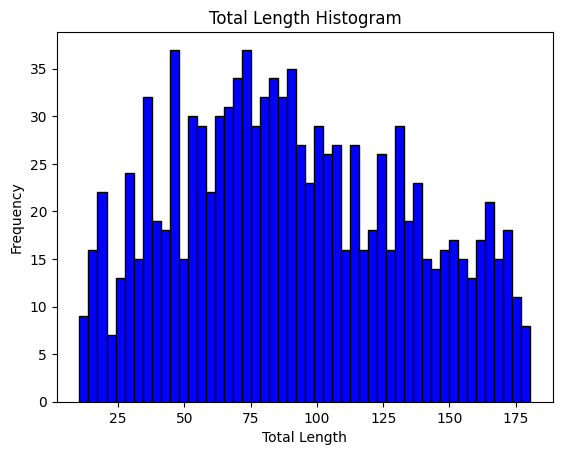

In [13]:
# plot TotalLength graph histogram
plt.hist(final_merged_maze_library_df["TotalLength"], bins=50, color='blue', edgecolor='black')
plt.xlabel('Total Length')
plt.ylabel('Frequency')
plt.title('Total Length Histogram')
plt.show()

In [14]:
TOTAL_MAZE_NUM = len(final_merged_maze_library_df)
TOTAL_DATA = TOTAL_MAZE_NUM * 192
EACH_SIM_TIME = 8
TOTAL_SIM_DAY = TOTAL_DATA * EACH_SIM_TIME / (60 * 60 * 24)

print(f"Total Maze Number: {TOTAL_MAZE_NUM}")
print(f"Total Data: {TOTAL_DATA}")
print(f"Total Simulation Time: {TOTAL_SIM_DAY} days")

Total Maze Number: 1104
Total Data: 211968
Total Simulation Time: 19.626666666666665 days


In [15]:
# save the final merged maze library
final_merged_maze_library_df.to_csv("new_maze_library.csv", index=False)